In [8]:
!pip install plotly

In [9]:
import pandas as pd

bookings = pd.read_csv('./bookings.csv')

### Fix typings

In [10]:
bookings['number_of_reviews'] = bookings['number_of_reviews'].str.replace(',', '', regex=True)
bookings['number_of_reviews'] = pd.to_numeric(bookings['number_of_reviews'], errors='coerce')
bookings['review_score'] = pd.to_numeric(bookings['review_score'], errors='coerce')
bookings['original_price'] = pd.to_numeric(bookings['original_price'], errors='coerce')
bookings['discounted_price'] = pd.to_numeric(bookings['discounted_price'], errors='coerce')

### Reviews Distribution
Group the review counts by snapshot dates, and the names of the hotels. the `number_of_reviews` will be a the same for the same hotel in a certain snapshot.   

In [11]:
number_of_reviews = bookings.groupby(['name', 'snapshot_date'], as_index=False)['number_of_reviews'].first()
number_of_reviews

,name,snapshot_date,number_of_reviews
0,1 Hotel Central Park,2025-02-02,556.0
1,1 Hotel Central Park,2025-02-03,556.0
2,17John,2025-02-02,209.0
3,17John,2025-02-03,209.0
4,2 Bedroom Cozy Central Apartment,2025-02-02,8.0
...,...,...,...
711,citizenM New York Times Square,2025-02-03,3999.0
712,"voco The Franklin New York, an IHG Hotel",2025-02-02,508.0
713,"voco The Franklin New York, an IHG Hotel",2025-02-03,508.0
714,"voco Times Square South New York, an IHG Hotel",2025-02-02,3803.0


In [12]:
snapshot_dates = bookings['snapshot_date'].unique()

In [13]:
import plotly.graph_objects as go

fig = go.Figure()

for date in snapshot_dates:
    data = number_of_reviews[number_of_reviews['snapshot_date'] == date]['number_of_reviews'].dropna()
    fig.add_trace(go.Histogram(x=data, name=str(date), opacity=0.5, autobinx=True))

# Update layout for better visualization
fig.update_layout(
    title= "Distribution of Number of Reviews for Each Snapshot Date",
    xaxis_title="Number of Reviews",
    yaxis_title="Frequency",
    barmode="overlay",  # Makes histograms overlap
    legend_title="Snapshot Date",
    width=1400,  # Increase figure width
    height=800   # Increase figure height
)

# Show interactive plot
fig.show()

In [14]:
# Drop NaN values from 'review_score'

import plotly.express as px

review_scores = bookings.groupby(['name', 'snapshot_date'], as_index=False)['review_score'].first()

# Create subplots for each snapshot date
fig = go.Figure()

for date in snapshot_dates:
    data = review_scores[review_scores['snapshot_date'] == date]['review_score'].dropna()
    fig.add_trace(go.Histogram(x=data, name=str(date), opacity=0.5, bingroup=100))

# Update layout to separate the graphs
fig.update_layout(
    title="Distribution of Review Scores for Each Snapshot Date",
    xaxis_title="Review Score",
    yaxis_title="Frequency",
    barmode='overlay',  # Ensures histograms are separate
    legend_title="Snapshot Date",
    width=1000,
    height=600
)

# Show interactive plot
fig.show()

In [15]:
price_data = bookings.groupby(['name', 'snapshot_date'], as_index=False)[['original_price', 'discounted_price']].first()

# Get unique snapshot dates
snapshot_dates = price_data['snapshot_date'].unique()

# Create subplots for each snapshot date
fig = go.Figure()

for date in snapshot_dates:
    snapshot_prices = price_data[price_data['snapshot_date'] == date]
    
    fig.add_trace(go.Histogram(
        x=snapshot_prices['original_price'].dropna(),
        name=f"Original Price - {date}",
        opacity=0.5
    ))
    
    fig.add_trace(go.Histogram(
        x=snapshot_prices['discounted_price'].dropna(),
        name=f"Discounted Price - {date}",
        opacity=0.3
    ))

# Update layout for better visualization
fig.update_layout(
    title="Distribution of Original and Discounted Prices for Each Snapshot Date",
    xaxis_title="Price",
    yaxis_title="Frequency",
    barmode='overlay',  # Ensures histograms overlap for comparison
    legend_title="Snapshot Date & Price Type",
    width=1000,
    height=600
)

# Show the interactive plot
fig.show()

The prices shown in the graph above do not account for the length of stay. The graph below displays the distribution of "price per night."

In [16]:
bookings['discounted_price_per_night'] = bookings['discounted_price'] / bookings['length_of_stay']
bookings['original_price_per_night'] = bookings['original_price'] / bookings['length_of_stay']

price_per_night_data = bookings.groupby(['name', 'snapshot_date'], as_index=False)[['original_price_per_night', 'discounted_price_per_night']].first()

# Get unique snapshot dates
snapshot_dates = price_per_night_data['snapshot_date'].unique()

# Create subplots for each snapshot date
fig = go.Figure()

for date in snapshot_dates:
    snapshot_prices = price_per_night_data[price_per_night_data['snapshot_date'] == date]
    
    fig.add_trace(go.Histogram(
        x=snapshot_prices['original_price_per_night'].dropna(),
        name=f"Original Price per night - {date}",
        opacity=0.5
    ))
    
    fig.add_trace(go.Histogram(
        x=snapshot_prices['discounted_price_per_night'].dropna(),
        name=f"Discounted Price per night - {date}",
        opacity=0.3
    ))

# Update layout for better visualization
fig.update_layout(
    title="Distribution of Original and Discounted Prices per night for Each Snapshot Date",
    xaxis_title="Price per night",
    yaxis_title="Frequency",
    barmode='overlay',  # Ensures histograms overlap for comparison
    legend_title="Snapshot Date & Price Type",
    width=1000,
    height=600
)

# Show the interactive plot
fig.show()

In [17]:
# Remove price outliers using Tukey's IQR method

new_bookings = bookings
Q1 = new_bookings["original_price"].quantile(0.25)
Q3 = new_bookings["original_price"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataset
new_bookings = new_bookings[(new_bookings["original_price"] >= lower_bound) & (new_bookings["original_price"] <= upper_bound)]

# Display the number of rows after filtering
print(f"Rows after filtering: {len(new_bookings)}, Rows before filtering: {len(bookings)}")

Rows before filtering: 29509, Rows after filtering: 29998


In [18]:
# Define ordinal mappings for review titles
review_title_mapping = {
    "Poor": 1,
    "Fair": 2,
    "Good": 3,
    "Very good": 4,
    "Fabulous": 5,
    "Excellent": 6
}

# Apply the mapping to review_title column
new_bookings["review_title"] = new_bookings["review_title"].map(review_title_mapping)

# Extract unique bed types
unique_beds = new_bookings["bed_type"].dropna().unique()
print("Unique bed types:", unique_beds)

# Example ranking for bed types (adjust as needed)
bed_type_mapping = {
    "Single Bed": 1,
    "Twin Bed": 2,
    "Double Bed": 3,
    "Queen Bed": 4,
    "King Bed": 5,
    "Extra Large Double Bed": 6  # Highest rank
}

# Apply bed type ranking
new_bookings["bed_type"] = new_bookings["bed_type"].map(bed_type_mapping)

# Show a preview of the transformed columns
print(new_bookings[["review_title", "bed_type"]].head())

Unique bed types: ['1 large double bed' '1 extra-large double bed' '1 double bed'
 '1 single bed' '2 single beds' '2 double beds' '2 large double beds'
 'Multiple bed types' '1 bunk bed' 'Private suite'
 '3 beds (2 doubles, 1 sofa bed)'
 '2 beds (1 extra-large double, 1 sofa bed)' '2 extra-large double beds'
 '2 beds (1 bunk bed, 1 large double)' '2 bunk beds'
 '2 beds (1 double, 1 sofa bed)' '2 beds (1 single, 1 extra-large double)'
 '3 single beds' '2 beds (1 single, 1 large double)'
 '2 beds (1 single, 1 double)' 'Beds: 1 double or 2 singles'
 '2 beds (1 sofa bed, 1 large double)'
 '4 beds (1 double, 1 bunk bed, 1 sofa bed, 1 large double)'
 '3 beds (1 bunk bed, 2 large doubles)']
   review_title  bed_type
0           4.0       NaN
1           3.0       NaN
2           5.0       NaN
3           3.0       NaN
4           3.0       NaN


C:\Users\Ilai\AppData\Local\Temp/ipykernel_4520/3850563945.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Ilai\AppData\Local\Temp/ipykernel_4520/3850563945.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd


# Select categorical columns
categorical_columns = ["free_cancellation", "prepayment_needed", "neighborhood"]

# Initialize OneHotEncoder
encoder = OneHotEncoder(drop="first", sparse=False)  # drop="first" avoids multicollinearity

# Fit and transform the data
encoded_data = encoder.fit_transform(new_bookings[categorical_columns])

# Create a DataFrame with new column names
#encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names(categorical_columns))

# Concatenate with the original DataFrame (excluding the original categorical columns)
new_bookings = pd.concat([new_bookings.drop(columns=categorical_columns), encoded_df], axis=1)

# Display first few rows of transformed data
print(new_bookings.head())

   Unnamed: 0                                               name  \
0         0.0                     Iroquois New York Times Square   
1         1.0          Four Points by Sheraton New York Downtown   
2         2.0  The Mayfair Hotel Times Square, Ascend Hotel C...   
3         3.0                         The Washington by LuxUrban   
4         4.0        Hampton Inn by Hilton New York Times Square   

   original_price  discounted_price discount  review_score  review_title  \
0           292.0             218.0     True           8.5           4.0   
1           130.0             111.0     True           7.8           3.0   
2           141.0             141.0    False           8.6           5.0   
3           160.0             160.0    False           7.7           3.0   
4           152.0             152.0    False           7.8           3.0   

   number_of_reviews  star_rating is_apartment  ...  \
0             2625.0          5.0        False  ...   
1             1987.0    

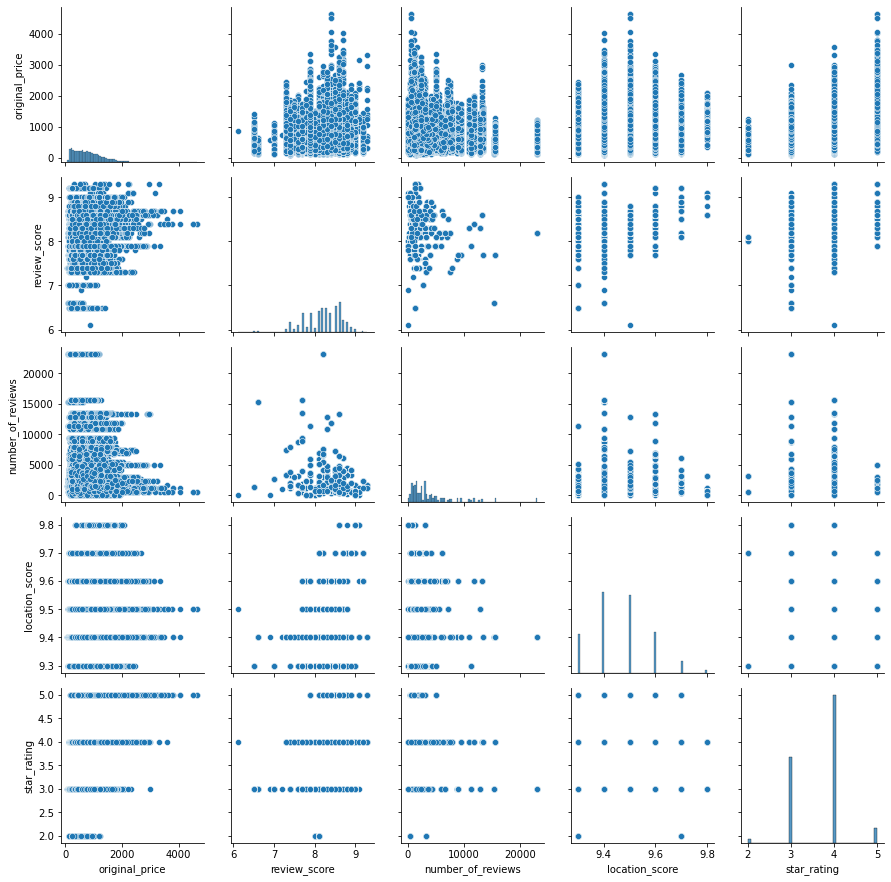

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical variables for PairGrid
selected_columns = ["original_price", "review_score", "number_of_reviews", "location_score", "star_rating"]
pairgrid_df = bookings[selected_columns].dropna()  # Drop NaN values for plotting

# Create PairGrid
g = sns.PairGrid(pairgrid_df)
g.map_diag(sns.histplot)  # Histograms on the diagonal
g.map_offdiag(sns.scatterplot)  # Scatter plots on off-diagonal

# Show the plot
plt.show()

In [23]:
new_bookings.to_csv('./proccessedBookings.csv')